# Xception
Xception 是由 François Chollet 在 2016 年提出的一种深度卷积神经网络结构，它是对 Inception 系列模型的思想延伸和改进。Xception 全称 Extreme Inception ，核心思想是将 Inception 模块的设计理念推向极致。

传统的Inception模块可以简化为下图所示的结构,现进行1x1的卷积,然后进行分组卷积.

  ![alt text](resources/xception_inception.png "Title")

xception将其推至极致,将分组卷积变为Depthwise卷积,注意1x1卷积和Depthwise的卷积顺序并不重要,但是两者之间没有非线性激活函数,它可能会导致信息丢失从而降低性能.

![alt text](resources/xception_xception.png "Title")

In [1]:
# 自动重新加载外部module，使得修改代码之后无需重新import
# see http://stackoverflow.com/questions/1907993/autoreload-of-modules-in-ipython
%load_ext autoreload
%autoreload 2

from hdd.device.utils import get_device

import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms

# 设置训练数据的路径
DATA_ROOT = "~/workspace/hands-dirty-on-dl/dataset"
# 设置TensorBoard的路径
TENSORBOARD_ROOT = "~/workspace/hands-dirty-on-dl/dataset"
# 设置预训练模型参数路径
TORCH_HUB_PATH = "~/workspace/hands-dirty-on-dl/pretrained_models"
torch.hub.set_dir(TORCH_HUB_PATH)
# 挑选最合适的训练设备
DEVICE = get_device(["cuda", "cpu"])
print("Use device: ", DEVICE)

Use device:  cuda


In [2]:
from hdd.dataset.imagenette_in_memory import ImagenetteInMemory
from hdd.data_util.auto_augmentation import ImageNetPolicy

from hdd.data_util.transforms import RandomResize
from torch.utils.data import DataLoader

TRAIN_MEAN = [0.4625, 0.4580, 0.4295]
TRAIN_STD = [0.2452, 0.2390, 0.2469]
train_dataset_transforms = transforms.Compose(
    [
        RandomResize([256, 296, 384]),  # 随机在三个size中选择一个进行resize
        transforms.RandomCrop(224),
        transforms.RandomHorizontalFlip(),
        ImageNetPolicy(),
        transforms.ToTensor(),
        transforms.Normalize(mean=TRAIN_MEAN, std=TRAIN_STD),
    ]
)
val_dataset_transforms = transforms.Compose(
    [
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize(mean=TRAIN_MEAN, std=TRAIN_STD),
    ]
)
train_dataset = ImagenetteInMemory(
    root=DATA_ROOT,
    split="train",
    size="full",
    download=True,
    transform=train_dataset_transforms,
)
val_dataset = ImagenetteInMemory(
    root=DATA_ROOT,
    split="val",
    size="full",
    download=True,
    transform=val_dataset_transforms,
)


def build_dataloader(batch_size, train_dataset, val_dataset):
    train_dataloader = DataLoader(
        train_dataset, batch_size=batch_size, shuffle=True, num_workers=8
    )
    val_dataloader = DataLoader(
        val_dataset, batch_size=batch_size, shuffle=False, num_workers=8
    )
    return train_dataloader, val_dataloader

In [3]:
from hdd.models.cnn.xception import XceptionNet
from hdd.train.classification_utils import (
    naive_train_classification_model,
    eval_image_classifier,
)
from hdd.models.nn_utils import count_trainable_parameter


def train_net(
    train_dataloader,
    val_dataloader,
    lr=1e-3,
    weight_decay=1e-3,
    max_epochs=200,
) -> tuple[XceptionNet, dict[str, list[float]]]:
    net = XceptionNet(num_classes=10, dropout=0.5).to(DEVICE)
    print(f"#Parameter: {count_trainable_parameter(net)}")
    criteria = nn.CrossEntropyLoss(label_smoothing=0.1)
    optimizer = torch.optim.AdamW(net.parameters(), lr=lr, weight_decay=weight_decay)
    scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(
        optimizer, max_epochs, eta_min=lr / 100
    )
    training_stats = naive_train_classification_model(
        net,
        criteria,
        max_epochs,
        train_dataloader,
        val_dataloader,
        DEVICE,
        optimizer,
        scheduler,
        verbose=True,
    )
    return net, training_stats


train_dataloader, val_dataloader = build_dataloader(64, train_dataset, val_dataset)

net, width_multiplier_1 = train_net(
    train_dataloader,
    val_dataloader,
    lr=0.001,
    weight_decay=0,
)

eval_result = eval_image_classifier(net, val_dataloader.dataset, DEVICE)
ss = [result.gt_label == result.predicted_label for result in eval_result]
print(f"#Parameter: {count_trainable_parameter(net)} Accuracy: {sum(ss) / len(ss)}")

#Parameter: 20877754
Epoch: 1/200 Train Loss: 2.1695 Accuracy: 0.2399 Time: 20.39241  | Val Loss: 1.8684 Accuracy: 0.3918
Epoch: 2/200 Train Loss: 1.9309 Accuracy: 0.3627 Time: 20.11423  | Val Loss: 1.9931 Accuracy: 0.4387
Epoch: 3/200 Train Loss: 1.7668 Accuracy: 0.4458 Time: 20.26295  | Val Loss: 1.6324 Accuracy: 0.5162
Epoch: 4/200 Train Loss: 1.6283 Accuracy: 0.5136 Time: 19.85652  | Val Loss: 1.6535 Accuracy: 0.5289
Epoch: 5/200 Train Loss: 1.5206 Accuracy: 0.5664 Time: 20.04877  | Val Loss: 1.2323 Accuracy: 0.7034
Epoch: 6/200 Train Loss: 1.4481 Accuracy: 0.6000 Time: 19.98762  | Val Loss: 1.3113 Accuracy: 0.6645
Epoch: 7/200 Train Loss: 1.3681 Accuracy: 0.6348 Time: 19.82165  | Val Loss: 1.2171 Accuracy: 0.7011
Epoch: 8/200 Train Loss: 1.3253 Accuracy: 0.6531 Time: 19.99217  | Val Loss: 1.3202 Accuracy: 0.6828
Epoch: 9/200 Train Loss: 1.2872 Accuracy: 0.6735 Time: 20.50219  | Val Loss: 1.1059 Accuracy: 0.7541
Epoch: 10/200 Train Loss: 1.2222 Accuracy: 0.7012 Time: 20.14038  | Va

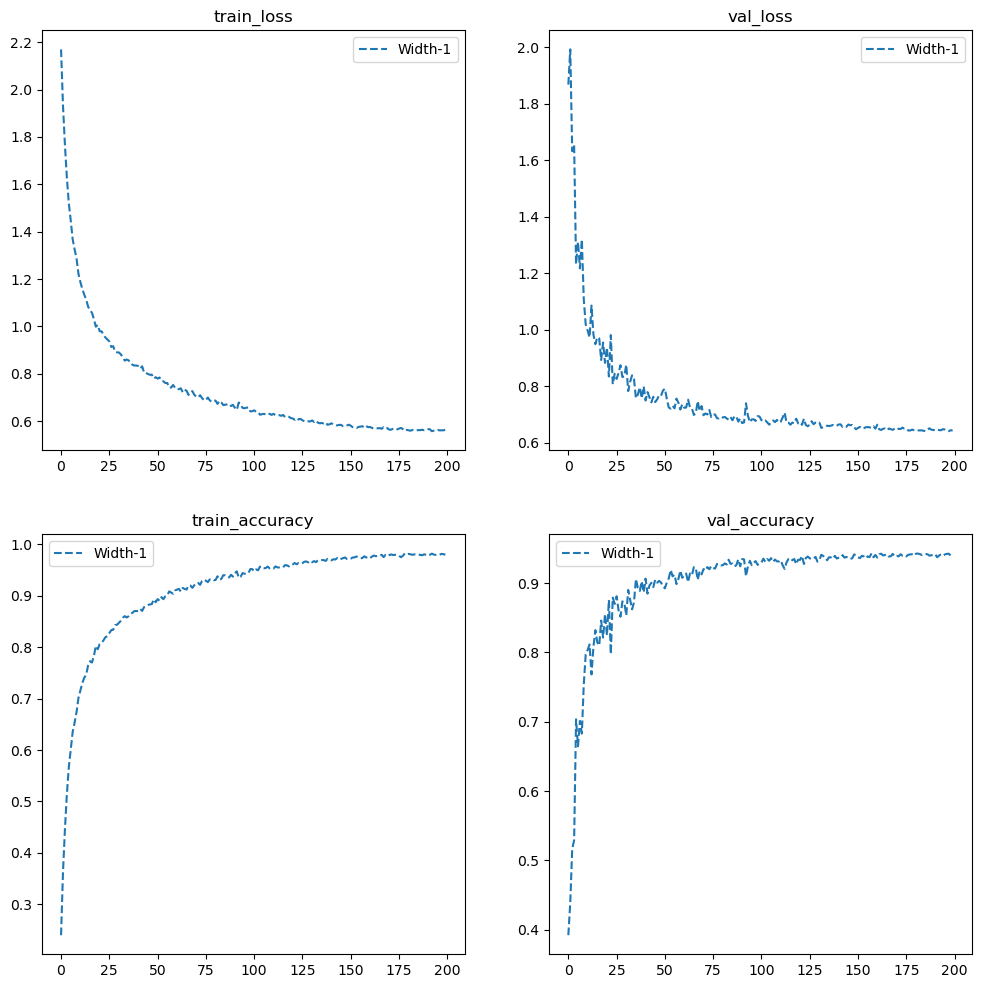

In [4]:
%matplotlib inline
import matplotlib.pyplot as plt
plt.figure(figsize=(12,12))
fields = width_multiplier_1.keys()
for i, field in enumerate(fields):
    plt.subplot(2, 2, i+1)
    plt.plot(width_multiplier_1[field], label="Width-1", linestyle="--")
    plt.legend()
    plt.title(field)